## **Simulando o Feixe**

Esse trabalho tem como objetivo simular o comportamento de um feixe de elétrons em acelerador linear, bem como a sua correção utilizando eletroímãs corretores.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 12 
})

Equações principais:

$$
\vec{F} = m \cdot \vec{a} = \frac{d\vec{p}}{dt}
$$

$$
\gamma = \sqrt{1 + \left(\frac{|\vec{v}|}{c} \right)^2} = \sqrt{1 + \left(\frac{|\vec{p}|}{m_0 c}\right)^2}
$$

$$
\vec{v} = \frac{\vec{v}}{\gamma} = \frac{\vec{p}}{m_0 \gamma} \approx c
$$

<!-- $$
\vec{v} = v_x \hat{i} + v_y \hat{j} + v_z \hat{k} \rightarrow |\vec{v}| = \sqrt{v_x^2 + v_y^2 + v_z^2} \approx c
$$ -->

$$
\vec{B} = B_x \hat{i} + B_y \hat{j} + B_z \hat{k}
$$

$$
\vec{F}^{N+1} = \vec{F}^{N} + \vec{f}_{ext} \cdot \Delta t = \vec{F}^{N} + q \cdot \vec{v} \times \vec{B} \cdot \Delta t
$$

In [2]:
CONSTANTES = {
    "V_LUZ": 2.99792458e8,
    "MASSA_E": 9.1093837e-31,
    "CARGA_E": -1.60217663e-19, 
}

parametros = {
    "vel0": [0, 0, 0.999999 * CONSTANTES["V_LUZ"]],
    "pos0": [0, 0, 0],
    "int_ruido": 0.008, # Tesla/m
    "grad_mag": 5,  
    "dt": 1e-12,
    "distancia": 3,
}       

In [3]:
class SimulacaoFeixeEletron():
    def __init__(self, parametros):
        """
        Inicializa a simulação recebendo um dicionário de parâmetros.
        """

        self.dt = parametros["dt"]
        self.ruido = parametros["int_ruido"]
        self.grad_B = parametros["grad_mag"]
        self.dist_total = parametros["distancia"]

        self.pos = np.array(parametros["pos0"], dtype=float)
        self.vel = np.array(parametros["vel0"], dtype=float)

        v_mag = np.linalg.norm(self.vel)
        self.gamma = 1.0 / np.sqrt(1.0 - (v_mag / CONSTANTES["V_LUZ"])**2)
        self.momento = CONSTANTES["MASSA_E"] * self.vel * self.gamma

        self.historico = {
            "t": [],
            "pos": [],
            "vel": [],
        }

    def _momento_para_velocidade(self, momento):
        """
        Converte o momento para velocidade considerando a correção de Lorentz
        """
        momento_norm = np.linalg.norm(momento)
        gamma = np.sqrt(1 + ((momento_norm)/(CONSTANTES["MASSA_E"] * CONSTANTES["V_LUZ"]))**2)

        return momento / (gamma * CONSTANTES["MASSA_E"])

    def _calcular_campo_B(self, posicao):
        """
        Calcula o campo magnético em uma posição.
        """
        Bx = self.grad_B * posicao[1]
        By = -self.grad_B * posicao[0]
        Bz = 0.0

        return np.array([Bx, By, Bz])
    
    def _calcular_forca_lorentz(self, velocidade, posicao):
        """
        Calcul a força de Lorentz: F = q * (v x B)
        """
        B = self._calcular_campo_B(posicao)

        return CONSTANTES["CARGA_E"] * np.cross(velocidade, B)

    def _aplicar_ruido(self, vec_momento):
        """
        Aplica um ruído aleatório no momento
        """
        # theta_x, theta_y, theta_z = np.random.uniform(-intensidade_max, intensidade_max, 3)
        theta_x, theta_y, theta_z = np.random.normal(0, (self.ruido)**2, 3)
        
        Rx = np.array([[1, 0, 0], [0, np.cos(theta_x), -np.sin(theta_x)], [0, np.sin(theta_x), np.cos(theta_x)]])
        
        Ry = np.array([[np.cos(theta_y), 0, np.sin(theta_y)], [0, 1, 0], [-np.sin(theta_y), 0, np.cos(theta_y)]])
        
        vetor_rotacionado = Ry @ (Rx @ vec_momento)
        
        return vetor_rotacionado

    def runge_kutta(self):
        """
        Faz os cálculos da simulação usando o Runge Kutta de quarta ordem.
        """
        t_total = self.dist_total / CONSTANTES["V_LUZ"]
        self.n_passos = int(t_total / self.dt)

        hist_pos = np.zeros((self.n_passos + 1, 3))
        hist_vel = np.zeros((self.n_passos + 1, 3))
        hist_t = np.arange(0, self.n_passos + 1) * self.dt
        
        r = self.pos.copy()
        p = self.momento.copy()
        v = self._momento_para_velocidade(p)
        dt = self.dt
    
        hist_pos[0] = r
        hist_vel[0] = v

        for i in range(self.n_passos):
            # k1
            momento_k1 = p
            v_k1 = self._momento_para_velocidade(momento_k1)
            pos_k1 = r
            forca_k1 = self._calcular_forca_lorentz(v_k1, pos_k1)

            # k2
            momento_k2 = p + 0.5*dt*forca_k1 
            v_k2 = self._momento_para_velocidade(momento_k2)
            pos_k2 = r + 0.5*dt*v_k1
            forca_k2 = self._calcular_forca_lorentz(v_k2, pos_k2)

            # k3
            momento_k3 = p + 0.5*dt*forca_k2
            v_k3 = self._momento_para_velocidade(momento_k3)
            pos_k3 = r + 0.5*dt*v_k2
            forca_k3 = self._calcular_forca_lorentz(v_k3, pos_k3)

            # k4
            momento_k4 = p + dt*forca_k3
            v_k4 = self._momento_para_velocidade(momento_k4)
            pos_k4 = r + dt*v_k3
            forca_k4 = self._calcular_forca_lorentz(v_k4, pos_k4)

            # Atualizando estados
            p += (self.dt / 6) * (forca_k1 + 2*forca_k2 + 2*forca_k3 + forca_k4)
            r += (self.dt / 6) * (v_k1 + 2*v_k2 + 2*v_k3 + v_k4)

            p = self._aplicar_ruido(p)
            v = self._momento_para_velocidade(p)

            hist_pos[i+1] = r
            hist_vel[i+1] = v

        self.historico["pos"] = hist_pos
        self.historico["vel"] = hist_vel
        self.historico["t"] = hist_t

In [4]:
np.random.seed(404)
parametros_com = parametros.copy()
parametros_com["grad_mag"] = 20.0
simulacao_com = SimulacaoFeixeEletron(parametros_com)
simulacao_com.runge_kutta()

### **Gráficos da simulação**

#### **Gráfico da Velocidade**

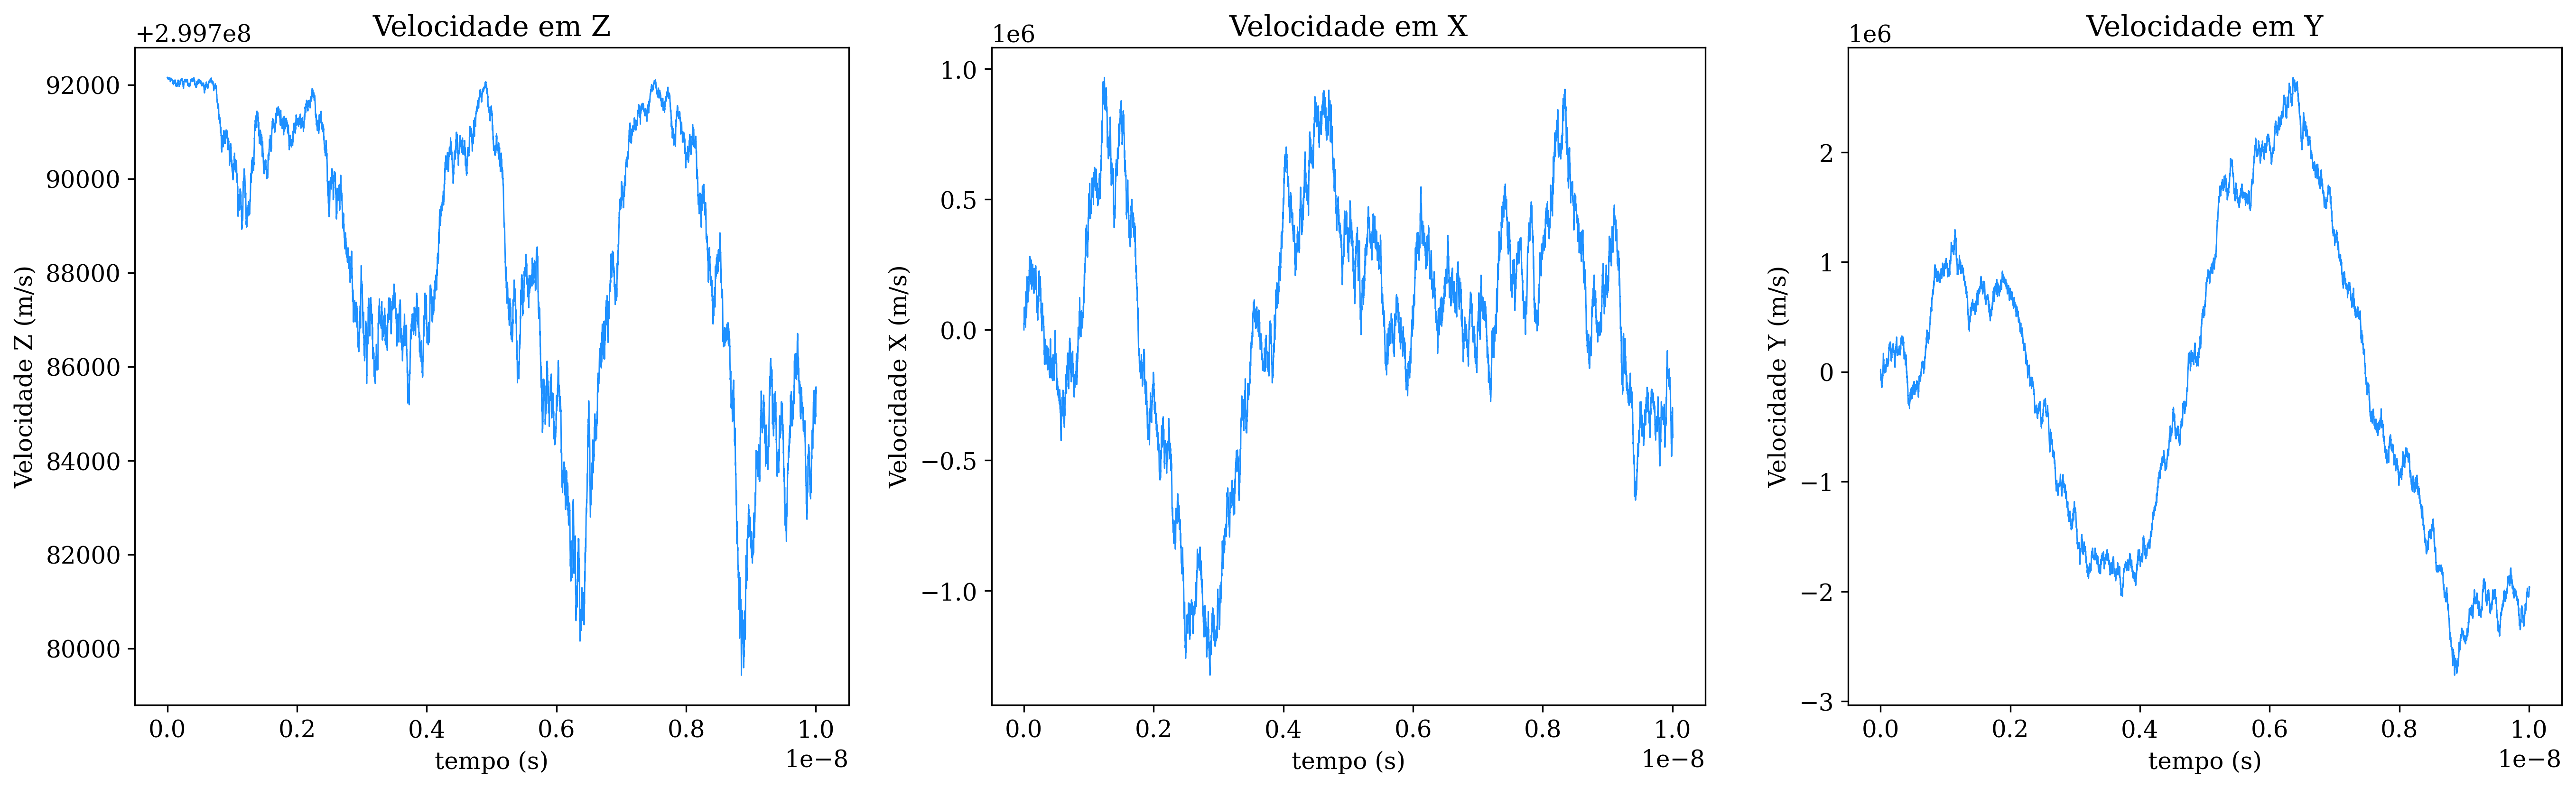

In [5]:
tempos_com = simulacao_com.historico["t"]
velocidades_com = simulacao_com.historico["vel"]
posicoes_com = simulacao_com.historico["pos"]

fig = plt.figure(figsize=(22, 6), dpi=300)
gs = gridspec.GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(tempos_com, velocidades_com[:, 2], color="dodgerblue", linewidth=0.7)
ax1.set_ylabel("Velocidade Z (m/s)")
ax1.set_xlabel("tempo (s)")
ax1.set_title("Velocidade em Z")

ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(tempos_com, velocidades_com[:, 0], color="dodgerblue", linewidth=0.7)
ax3.set_ylabel("Velocidade X (m/s)")
ax3.set_xlabel("tempo (s)")
ax3.set_title("Velocidade em X")

ax4 = fig.add_subplot(gs[0, 2])
ax4.plot(tempos_com, velocidades_com[:, 1], color="dodgerblue", linewidth=0.7)
ax4.set_ylabel("Velocidade Y (m/s)")
ax4.set_xlabel("tempo (s)")
ax4.set_title("Velocidade em Y")

plt.show()

#### **Gráfico da Posição**

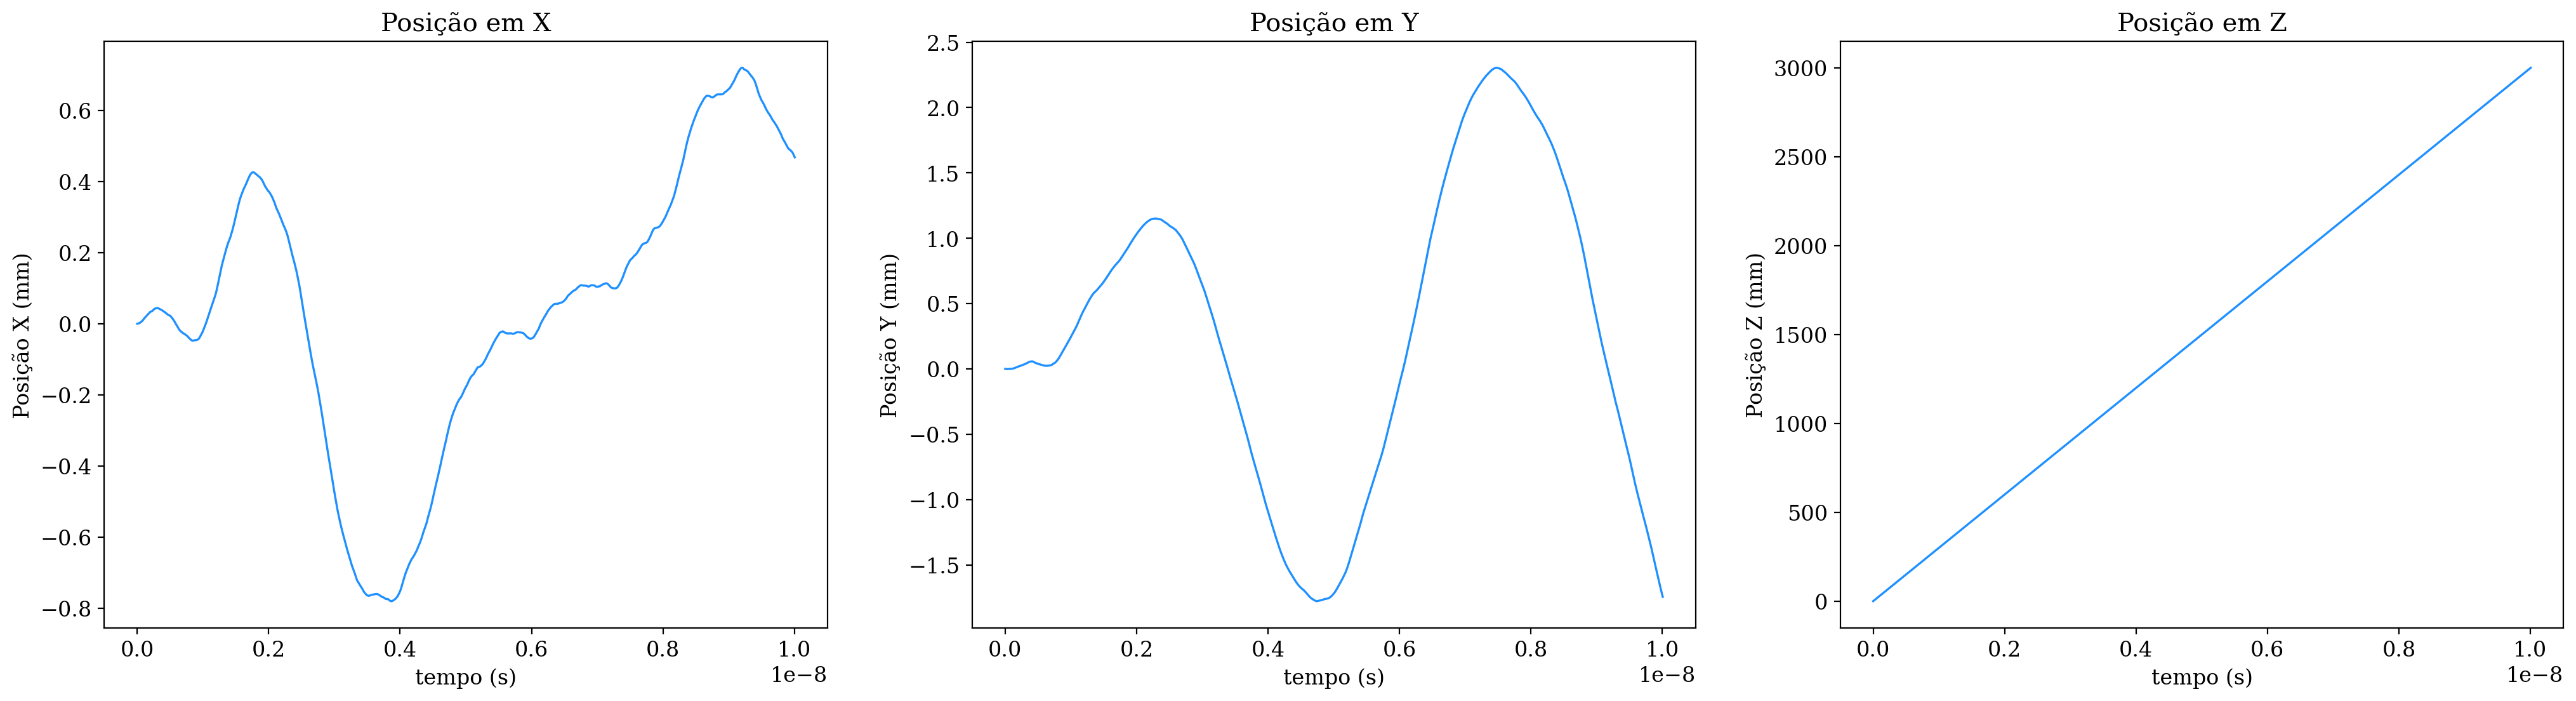

A média dos desvios em X foi: 0.3161082153106272 mm
O desvio padrão dos desvios em X foi: 0.2564856027368504 mm
O desvio máximo em X foi: 0.7802926022597675 mm


In [6]:
fig = plt.figure(figsize=(25, 6), dpi=200)
gs = gridspec.GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(tempos_com, posicoes_com[:, 0] * 1000, color="dodgerblue", linewidth=1.2)
# ax1.set_ylim(-max(abs(posicoes_com[:,0])) * 1000, max(abs(posicoes_com[:,0])) * 1000)
ax1.set_ylabel("Posição X (mm)")
ax1.set_xlabel("tempo (s)")
ax1.set_title("Posição em X")

ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(tempos_com, posicoes_com[:, 1] * 1000, color="dodgerblue", linewidth=1.2)
# ax3.set_ylim(-max(abs(posicoes_com[:,1])) * 1000, max(abs(posicoes_com[:,1])) * 1000)
ax3.set_ylabel("Posição Y (mm)")
ax3.set_xlabel("tempo (s)")
ax3.set_title("Posição em Y")

ax4 = fig.add_subplot(gs[0, 2])
ax4.plot(tempos_com, posicoes_com[:, 2] * 1000, color="dodgerblue", linewidth=1.2)
ax4.set_ylabel("Posição Z (mm)")
ax4.set_xlabel("tempo (s)")
ax4.set_title("Posição em Z")

plt.show()

desvios_x_com = abs(posicoes_com[:,0] - parametros["pos0"][0])

print(f"A média dos desvios em X foi: {np.mean(desvios_x_com) * 1000} mm")
print(f"O desvio padrão dos desvios em X foi: {np.std(desvios_x_com) * 1000} mm")
print(f"O desvio máximo em X foi: {max(desvios_x_com) * 1000} mm")

#### **Gráfico com a Compração das Trajetórias com e sem Correção**

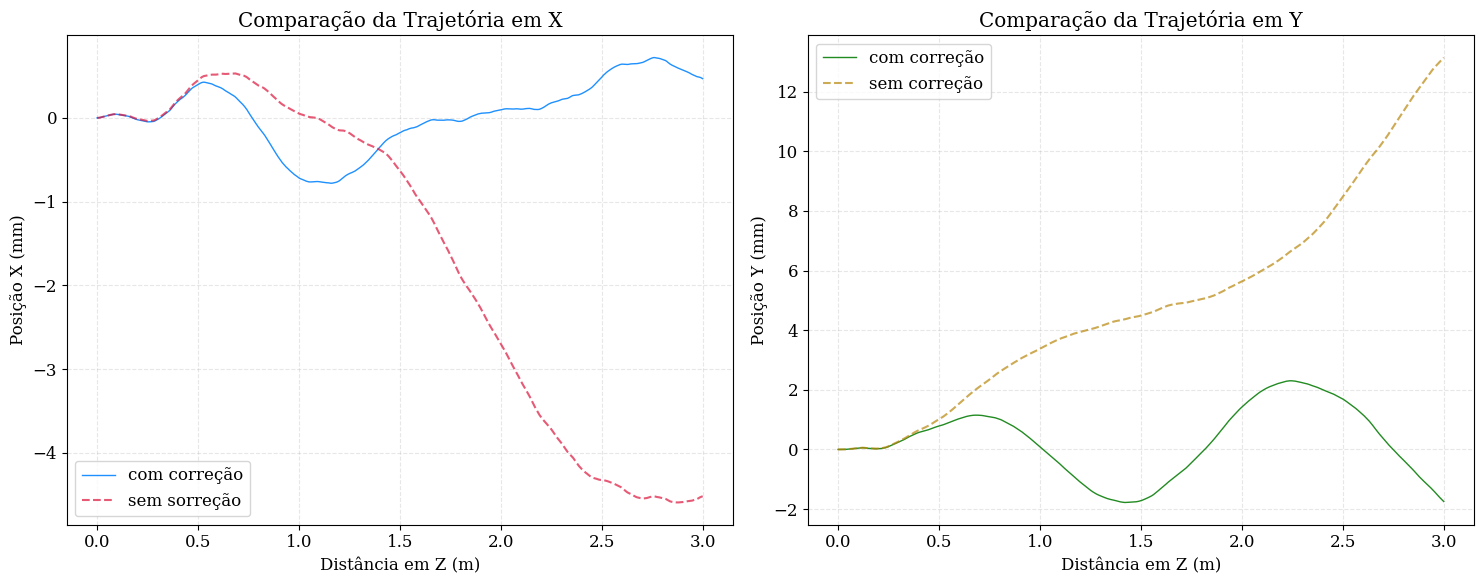

Desvio máximo em X (com correção): 0.7802926022597675 mm
Desvio máximo em X (sem correção): 4.591324014309118 mm

Desvio máximo em Y (com correção): 2.3043804142432345 mm
Desvio máximo em Y (sem correção): 13.145667226101896 mm


In [7]:
np.random.seed(404)
parametros_sem = parametros.copy()
parametros_sem["grad_mag"] = 0.0
simulacao_sem = SimulacaoFeixeEletron(parametros_sem)
simulacao_sem.runge_kutta()

tempos_sem = simulacao_sem.historico["t"]
velocidades_sem = simulacao_sem.historico["vel"]
posicoes_sem = simulacao_sem.historico["pos"]

fig = plt.figure(figsize=(15, 6), dpi=100)
gs = gridspec.GridSpec(1, 2, figure=fig)

z_com = simulacao_com.historico["pos"][:, 2]
x_com = simulacao_com.historico["pos"][:, 0] * 1000
y_com = simulacao_com.historico["pos"][:, 1] * 1000

z_sem = simulacao_sem.historico["pos"][:, 2]
x_sem = simulacao_sem.historico["pos"][:, 0] * 1000
y_sem = simulacao_sem.historico["pos"][:, 1] * 1000

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(z_com, x_com, label="com correção", color="dodgerblue", linewidth=1)
ax1.plot(z_sem, x_sem, label="sem sorreção", color="crimson", linestyle="--", alpha=0.7)
ax1.set_ylabel("Posição X (mm)")
ax1.set_xlabel("Distância em Z (m)")
ax1.set_title("Comparação da Trajetória em X")
ax1.legend()
ax1.grid(True, linestyle="--", alpha=0.3)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(z_com, y_com, label="com correção", color="forestgreen", linewidth=1)
ax2.plot(z_sem, y_sem, label="sem correção", color="darkgoldenrod", linestyle="--", alpha=0.7)
ax2.set_ylabel("Posição Y (mm)")
ax2.set_xlabel("Distância em Z (m)")
ax2.set_title("Comparação da Trajetória em Y")
ax2.legend()
ax2.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Desvio máximo em X (com correção): {np.max(abs(x_com))} mm")
print(f"Desvio máximo em X (sem correção): {np.max(abs(x_sem))} mm")

print(f"\nDesvio máximo em Y (com correção): {np.max(abs(y_com))} mm")
print(f"Desvio máximo em Y (sem correção): {np.max(abs(y_sem))} mm")

### **Animação da Simulação**

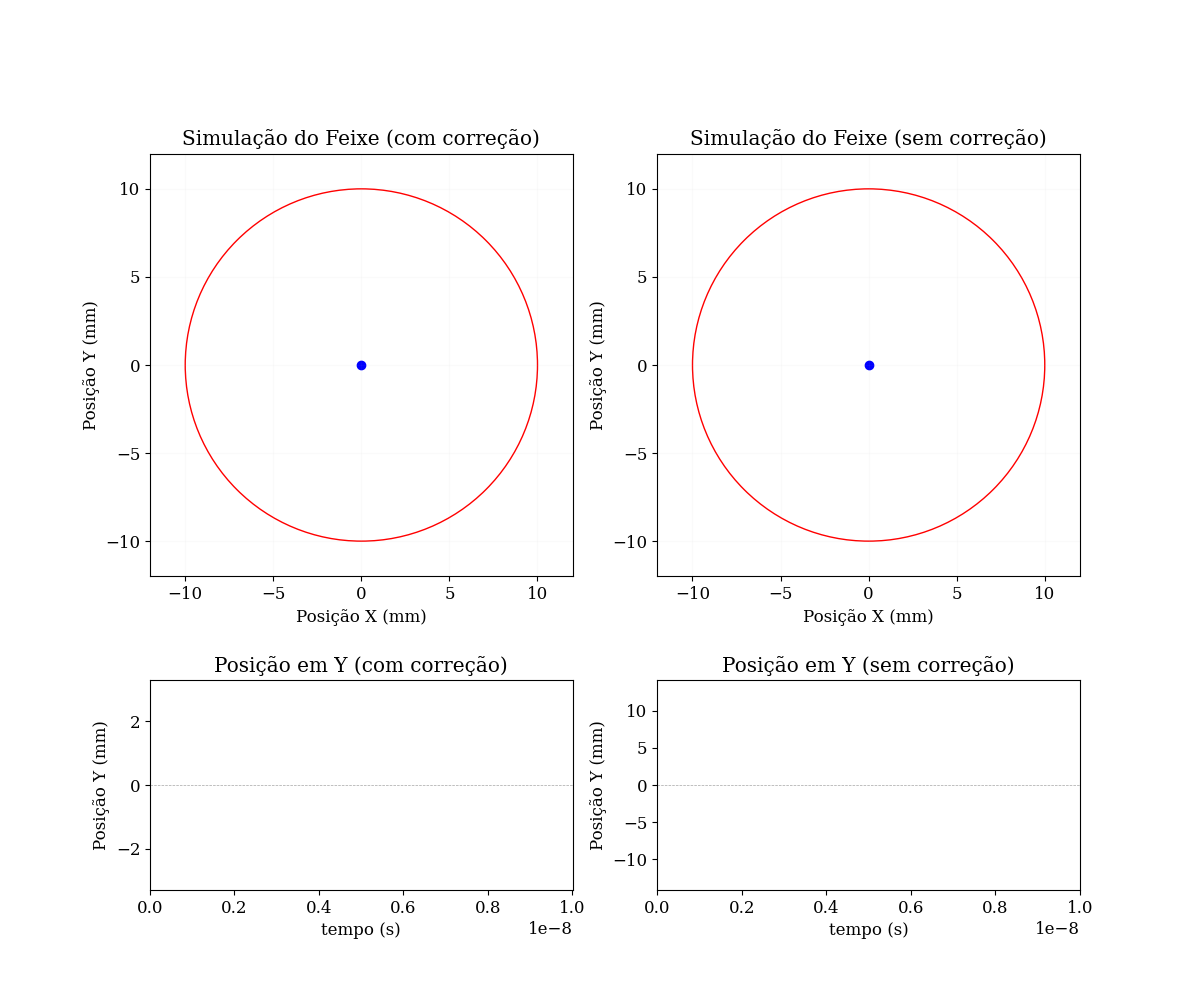

In [8]:
%matplotlib widget

anim = None  
try:
    anim.event_source.stop()
except AttributeError:
    pass
plt.close("all")

fig = plt.figure(figsize=(12, 10))
fig.canvas.header_visible = False  

gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[0.7, 0.3])

ax1 = fig.add_subplot(gs[0,0])
ax1.set_xlim(parametros["pos0"][0]-12, parametros["pos0"][0]+12)
ax1.set_ylim(parametros["pos0"][1]-12, parametros["pos0"][1]+12)
ax1.set_ylabel("Posição Y (mm)")
ax1.set_xlabel("Posição X (mm)")
ax1.set_title(f"Simulação do Feixe (com correção)")
ax1.set_aspect("equal") 
ax1.grid(True, alpha=0.05)

ax2 = fig.add_subplot(gs[0,1])
ax2.set_xlim(parametros["pos0"][0]-12, parametros["pos0"][0]+12)
ax2.set_ylim(parametros["pos0"][1]-12, parametros["pos0"][1]+12)
ax2.set_ylabel("Posição Y (mm)")
ax2.set_xlabel("Posição X (mm)")
ax2.set_title(f"Simulação do Feixe (sem correção)")
ax2.set_aspect("equal") 
ax2.grid(True, alpha=0.05)

ax3 = fig.add_subplot(gs[1,0])
ax3.set_ylabel("Posição Y (mm)")
ax3.set_xlabel("tempo (s)")
ax3.set_title("Posição em Y (com correção)")

t_max_com = max(tempos_com)
dados_y_com = posicoes_com[:,1] * 1000 
max_var_y_com = max(abs(dados_y_com))
ax3.set_xlim(0, t_max_com)
ax3.set_ylim(-max_var_y_com - 1, max_var_y_com + 1)
ax3.hlines(parametros["pos0"][0], 0, t_max_com, alpha=0.7, color="gray", linewidth=0.5, linestyle="--")
linha_y_com, = ax3.plot([], [], color="dodgerblue", linewidth=1)

ax4 = fig.add_subplot(gs[1,1])
ax4.set_ylabel("Posição Y (mm)")
ax4.set_xlabel("tempo (s)")
ax4.set_title("Posição em Y (sem correção)")

t_max_sem = max(tempos_sem)
dados_y_sem = posicoes_sem[:, 1] * 1000
max_var_y_sem = max(abs(dados_y_sem))
ax4.set_xlim(0, t_max_sem)
ax4.set_ylim(-max_var_y_sem - 1, max_var_y_sem + 1)
ax4.hlines(parametros["pos0"][0], 0, t_max_sem, alpha=0.7, color="gray", linewidth=0.5, linestyle="--")
linha_y_sem, = ax4.plot([], [], color="dodgerblue", linewidth=1)

time_text = fig.text(0.02, 1.10, "", transform=ax1.transAxes, bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

pos_x_inicial_mm = parametros["pos0"][0] * 1000
pos_y_inicial_mm = parametros["pos0"][1] * 1000

fig_eletron_com = ax1.scatter(pos_x_inicial_mm, pos_y_inicial_mm, color="blue")
fig_eletron_sem = ax2.scatter(pos_x_inicial_mm, pos_y_inicial_mm, color="blue")
fig_anel_com = Circle((parametros["pos0"][0], parametros["pos0"][1]), radius=10, fill=False, color="r")
fig_anel_sem = Circle((parametros["pos0"][0], parametros["pos0"][1]), radius=10, fill=False, color="r")

ax1.add_patch(fig_anel_com)
ax2.add_patch(fig_anel_sem)

def animate(frame):
    pos_x_com = posicoes_com[frame, 0] * 1000
    pos_y_com = posicoes_com[frame, 1] * 1000
    pos_z_com = posicoes_com[frame, 2]

    pos_x_sem = posicoes_sem[frame, 0] * 1000
    pos_y_sem = posicoes_sem[frame, 1] * 1000
    pos_z_sem = posicoes_sem[frame, 2]

    fig_eletron_com.set_offsets(np.array([[pos_x_com, pos_y_com]]))
    fig_eletron_sem.set_offsets(np.array([[pos_x_sem, pos_y_sem]]))

    t_dados_com = tempos_com[:frame]
    y_dados_com = posicoes_com[:frame, 1] * 1000
    linha_y_com.set_data(t_dados_com, y_dados_com)

    t_dados_sem = tempos_sem[:frame]
    y_dados_sem = posicoes_sem[:frame, 1] * 1000
    linha_y_sem.set_data(t_dados_sem, y_dados_sem)

    tempo_atual = tempos_com[frame]
    time_text.set_text(f"Passo: {frame} | Tempo: {tempo_atual:.12f}s")

    return fig_eletron_com, fig_eletron_sem, time_text, linha_y_com, linha_y_sem

n_passos = simulacao_com.n_passos
anim = FuncAnimation(fig, animate, frames=range(0, n_passos, 10), interval=28, blit=True, repeat=False)
plt.show()

**Melhorias**:

- Implementar os diferentes tipos de corretoras (dipolo, quadrupolo, sextupolo).